## Data Processing

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
from xgboost import cv
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_excel('train_data.xlsx')
test = pd.read_excel('test_data_corrected.xlsx')

In [ ]:
data = pd.concat([train, test], ignore_index=True)

In [ ]:
train_target = pd.read_excel('train_data.xlsx', sheet_name=1)
test_target = pd.read_excel('test_data_corrected.xlsx', sheet_name=1)

target = pd.concat([train_target, test_target], ignore_index=True)

In [ ]:
# Converting to binary (0 = sufficient, 1 = insufficient)
target_class = list(map(lambda x: 0 if x > 90 else 1, target.values))

In [ ]:
# Processing data pipeline
transformer = Pipeline([
                    ('imputer',SimpleImputer()),
                    ('scaler', StandardScaler()),      
])

In [ ]:
# Setting up metrics to use during evaluation
metrics = {'accuracy': 'accuracy', 'precision': make_scorer(precision_score, average="binary", pos_label=1), 'recall': make_scorer(recall_score, average="binary", pos_label=1), 'mcc': 'matthews_corrcoef'}

In [ ]:
# Renaming columns with special characters
data.rename(columns={'Preculture Time [h]': 'Preculture Time', 'Start Preculture Perfusion [h after inoc] d1-d2': 'Start Preculture Perfusion d1-d2','Presence of  IWP2 [h]': 'Presence of  IWP2' }, inplace=True)

## Feature Selection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

'''# Load data from Excel file
data = pd.read_excel('test_data_corrected.xlsx')#change filename

# Separate target variable from features
target_col = 'Target Variable'
X = data.drop(target_col, axis=1)
y = data[target_col]'''

X = data
y = target

# Perform Monte Carlo feature selection with 100 iterations
num_features = X.shape[1]
num_iterations = 100
scores = np.zeros((num_iterations, num_features))
for i in range(num_iterations):
    # Shuffle feature columns
    X_shuffled = X.sample(frac=1, axis=1)
    # Select k best features using mutual information
    selector = SelectKBest(mutual_info_regression, k=5)
    selector.fit(X_shuffled, y)
    scores[i,:] = selector.scores_

# Calculate mean score for each feature
mean_scores = np.mean(scores, axis=0)

# Print ranked list of features based on mean score
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Score': mean_scores})
feature_ranking = feature_ranking.sort_values(by='Score', ascending=False)

 

In [ ]:
print(feature_ranking)

                                  Feature     Score
16        dd2-dd3 Aggregate Size Gradient  0.079458
85                dd4 Average pH Gradient  0.078330
69                     Overall Average pH  0.075857
14        dd1-dd2 Aggregate Size Gradient  0.074093
30           Average DO concentration dd3  0.073787
..                                    ...       ...
77                dd0 Average pH Gradient  0.053533
72                          d0 Average pH  0.052745
7           dd3-dd5 Cell Density Gradient  0.052704
66       dd3 DO 2nd derivative/cell count  0.052237
39  Average DO concentration gradient dd2  0.047914

[102 rows x 2 columns]


## Classification

In [ ]:
# Setting up list of estimators for classification
estimators = [
    ('xgboost', xgb.XGBClassifier(objective="binary:logistic", random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, max_features=3)),
    ('adaboost', AdaBoostClassifier(n_estimators=50, estimator=DecisionTreeClassifier(max_depth=1) ,learning_rate=1))
]

In [ ]:
# Column names for results
col_names = ['feature set', 'accuracy', 'precision_score', 'recall_score', 'mcc']

### XGBoost

In [ ]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# Setting up transformation/model pipeline
xgb_model = Pipeline(steps=[('scale', transformer), ('xgb', xgb.XGBClassifier(objective="binary:logistic", random_state=42))])

# 10 fold cross-validation
result = cross_validate(xgb_model, data, target_class, cv=10, scoring=metrics)

# Create a dataframe with metrics
row = [['XGBoost', '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]

xgb_metrics = pd.DataFrame(row, columns=col_names)
xgb_metrics


,feature set,accuracy,precision_score,recall_score,mcc
0,XGBoost,0.800 +/- 0.100,0.840 +/- 0.113,0.905 +/- 0.117,0.474 +/- 0.313


Feature Selection Using SciKit Learn:

In [ ]:
sfs = SequentialFeatureSelector(xgb_model, n_features_to_select=15)
sfs.fit(data, target_class)

SequentialFeatureSelector(estimator=Pipeline(steps=[('scale',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer()),
                                                                     ('scaler',
                                                                      StandardScaler())])),
                                                    ('xgb',
                                                     XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types...
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=42, ...))]),
                          n_features_to_select=15)

In [ ]:
columns = data.columns

print(
    "Features selected by forward sequential selection: "
    f"{columns[sfs.get_support()]}"
)

data_reduced = sfs.transform(data)
print(data_reduced.shape)

Features selected by forward sequential selection: Index(['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density',
       'dd1-dd2 Cell Density Gradient', 'dd3 Cell Density ', 'Preculture Time',
       'Start Preculture Perfusion d1-d2', 'Presence of  IWP2',
       'Average DO concentration gradient dd0',
       'Average DO concentration gradient dd1',
       'DO concentration/cell count dd1', 'DO gradient/cell count dd1',
       'DO gradient/cell count dd2', 'DO gradient/cell count dd7',
       'dd2 Average of 2nd derivative DO', 'dd1 Average pH Gradient'],
      dtype='object')
(60, 15)


In [ ]:
# Running with reduced features
result = cross_validate(xgb_model, data_reduced, target_class, cv=10, scoring=metrics)

# create a dataframe with metrics
row = [['XGBoost (FS1)', '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]

xgb_metrics = pd.DataFrame(row, columns=col_names)
xgb_metrics

,feature set,accuracy,precision_score,recall_score,mcc
0,XGBoost (FS1),0.833 +/- 0.129,0.885 +/- 0.122,0.905 +/- 0.162,0.565 +/- 0.364


Feature Selection Using Mlxtend:

In [ ]:
sfs = SFS(xgb_model, k_features=15)
sfs.fit(data, target_class)

SequentialFeatureSelector(estimator=Pipeline(steps=[('scale',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer()),
                                                                     ('scaler',
                                                                      StandardScaler())])),
                                                    ('xgb',
                                                     XGBClassifier(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types...
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=42, ...))]),
                          k_features=15)

In [ ]:
# Dataframe with results from feature selection
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)","[0.9166666666666666, 0.9166666666666666, 0.75,...",0.8,"(dd1 Cell Density,)",0.160304,0.124722,0.062361
2,"(2, 59)","[0.9166666666666666, 0.9166666666666666, 0.916...",0.866667,"(dd1 Cell Density, dd2 Average of 2nd derivati...",0.085686,0.066667,0.033333
3,"(2, 56, 59)","[1.0, 1.0, 0.8333333333333334, 0.75, 0.8333333...",0.883333,"(dd1 Cell Density, DO gradient/cell count dd7,...",0.128529,0.1,0.05
4,"(2, 53, 56, 59)","[1.0, 1.0, 0.8333333333333334, 0.9166666666666...",0.916667,"(dd1 Cell Density, DO gradient/cell count dd2,...",0.0958,0.074536,0.037268
5,"(2, 22, 53, 56, 59)","[1.0, 1.0, 0.8333333333333334, 0.9166666666666...",0.916667,"(dd1 Cell Density, Preculture Time, DO gradien...",0.0958,0.074536,0.037268
6,"(2, 22, 23, 53, 56, 59)","[1.0, 1.0, 0.8333333333333334, 0.9166666666666...",0.916667,"(dd1 Cell Density, Preculture Time, Start Prec...",0.0958,0.074536,0.037268
7,"(2, 22, 23, 24, 53, 56, 59)","[1.0, 1.0, 0.8333333333333334, 0.9166666666666...",0.916667,"(dd1 Cell Density, Preculture Time, Start Prec...",0.0958,0.074536,0.037268
8,"(2, 22, 23, 24, 44, 53, 56, 59)","[1.0, 1.0, 0.8333333333333334, 0.9166666666666...",0.916667,"(dd1 Cell Density, Preculture Time, Start Prec...",0.0958,0.074536,0.037268
9,"(2, 6, 22, 23, 24, 44, 53, 56, 59)","[0.9166666666666666, 1.0, 0.8333333333333334, ...",0.883333,"(dd1 Cell Density, dd3 Cell Density , Precultu...",0.085686,0.066667,0.033333
10,"(2, 6, 22, 23, 24, 38, 44, 53, 56, 59)","[0.9166666666666666, 1.0, 0.8333333333333334, ...",0.883333,"(dd1 Cell Density, dd3 Cell Density , Precultu...",0.085686,0.066667,0.033333


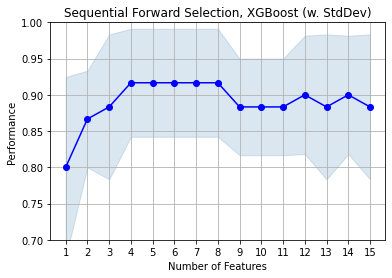

In [ ]:
# Plotting results
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.7, 1])
plt.title('Sequential Forward Selection, XGBoost (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
print('Top 6 Features:')
print('highest score: ' + str(sfs.subsets_[6]['avg_score']))
print('highest indexes: ' + str(sfs.subsets_[6]['feature_idx']))
print('feature names: ' + str(sfs.subsets_[6]['feature_names']))

print('Top 7 Features:')
print('highest score: ' + str(sfs.subsets_[7]['avg_score']))
print('highest indexes: ' + str(sfs.subsets_[7]['feature_idx']))
print('feature names: ' + str(sfs.subsets_[7]['feature_names']))

print('Top 8 Features:')
print('highest score: ' + str(sfs.subsets_[8]['avg_score']))
print('highest indexes: ' + str(sfs.subsets_[8]['feature_idx']))
print('feature names: ' + str(sfs.subsets_[8]['feature_names']))

Top 6 Features:
highest score: 0.9166666666666666
highest indexes: (2, 22, 23, 53, 56, 59)
feature names: ('dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'DO gradient/cell count dd2', 'DO gradient/cell count dd7', 'dd2 Average of 2nd derivative DO')
Top 7 Features:
highest score: 0.9166666666666666
highest indexes: (2, 22, 23, 24, 53, 56, 59)
feature names: ('dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'Presence of  IWP2', 'DO gradient/cell count dd2', 'DO gradient/cell count dd7', 'dd2 Average of 2nd derivative DO')
Top 8 Features:
highest score: 0.9166666666666666
highest indexes: (2, 22, 23, 24, 44, 53, 56, 59)
feature names: ('dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'Presence of  IWP2', 'Average DO concentration gradient dd7', 'DO gradient/cell count dd2', 'DO gradient/cell count dd7', 'dd2 Average of 2nd derivative DO')


In [ ]:
# Running model with reduced features
data_reduced = data[list(sfs.subsets_[6]['feature_names'])]

result = cross_validate(xgb_model, data_reduced, target_class, cv=10, scoring=metrics)

# create a dataframe with metrics
row = [['XGBoost (FS1)', '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]

xgb_metrics = pd.DataFrame(row, columns=col_names)
xgb_metrics

,feature set,accuracy,precision_score,recall_score,mcc
0,XGBoost (FS1),0.883 +/- 0.130,0.905 +/- 0.123,0.950 +/- 0.100,0.659 +/- 0.403


### RandomForest

In [ ]:
# Running with entire dataset (all features)
rf = Pipeline(steps=[('scale', transformer), ('rf', RandomForestClassifier(n_estimators=100, max_features=3))])

#rf = RandomForestRegressor(n_estimators=100, random_state=0, max_features=3)

result = cross_validate(rf, data, target_class, cv=10, scoring=metrics)

# create a dataframe with metrics
row = [['Random Forest', '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]

metrics_df = pd.DataFrame(row, columns=col_names)
metrics_df

,model,accuracy,precision_score,recall_score,mcc
0,Random Forest,0.700 +/- 0.125,0.728 +/- 0.080,0.900 +/- 0.166,0.120 +/- 0.286


Feature selection with sklearn:

In [ ]:
sfs1 = SequentialFeatureSelector(rf, n_features_to_select=5)
sfs1.fit(data, target_class)

columns = data.columns

print(
    "Features selected by forward sequential selection: "
    f"{columns[sfs1.get_support()]}"
)

data_reduced_rf = sfs1.transform(data)
print(data_reduced_rf.shape)

Features selected by forward sequential selection: Index(['dd1 Cell Density', 'dd2-dd3 Cell Density Gradient',
       'dd0 Average of 2nd derivative DO', 'dd3 DO 2nd derivative/cell count',
       'dd2 Average pH'],
      dtype='object')
(60, 5)


In [ ]:
result = cross_validate(rf, data_reduced_rf, target_class, cv=10, scoring=metrics)

# create a dataframe with metrics
row = [['Random Forest (FS1)', '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]

metrics_df = pd.DataFrame(row, columns=col_names)
metrics_df

,feature set,accuracy,precision_score,recall_score,mcc
0,Random Forest (FS1),0.867 +/- 0.145,0.877 +/- 0.128,0.950 +/- 0.100,0.676 +/- 0.367


With mlxtend:

In [ ]:
sfs = SFS(rf, k_features=15)
sfs.fit(data, target_class)

SequentialFeatureSelector(estimator=Pipeline(steps=[('scale',
                                                     Pipeline(steps=[('imputer',
                                                                      SimpleImputer()),
                                                                     ('scaler',
                                                                      StandardScaler())])),
                                                    ('rf',
                                                     RandomForestClassifier(max_features=3))]),
                          k_features=15)

In [ ]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(80,)","[0.8333333333333334, 0.75, 0.8333333333333334,...",0.783333,"(dd2 Average pH,)",0.085686,0.066667,0.033333
2,"(2, 80)","[0.9166666666666666, 1.0, 0.6666666666666666, ...",0.816667,"(dd1 Cell Density, dd2 Average pH)",0.171372,0.133333,0.066667
3,"(2, 8, 80)","[1.0, 1.0, 0.75, 0.6666666666666666, 0.8333333...",0.85,"(dd1 Cell Density, dd5 Cell Density, dd2 Avera...",0.171372,0.133333,0.066667
4,"(2, 8, 20, 80)","[1.0, 1.0, 0.75, 0.6666666666666666, 0.8333333...",0.85,"(dd1 Cell Density, dd5 Cell Density, dd7 Aggre...",0.171372,0.133333,0.066667
5,"(2, 7, 8, 20, 80)","[1.0, 1.0, 0.75, 0.6666666666666666, 0.8333333...",0.85,"(dd1 Cell Density, dd3-dd5 Cell Density Gradie...",0.171372,0.133333,0.066667
6,"(2, 7, 8, 13, 20, 80)","[1.0, 1.0, 0.75, 0.6666666666666666, 0.8333333...",0.85,"(dd1 Cell Density, dd3-dd5 Cell Density Gradie...",0.171372,0.133333,0.066667
7,"(2, 4, 7, 8, 13, 20, 80)","[0.9166666666666666, 1.0, 0.75, 0.666666666666...",0.85,"(dd1 Cell Density, dd2 Cell Density, dd3-dd5 C...",0.157415,0.122474,0.061237
8,"(2, 4, 7, 8, 13, 14, 20, 80)","[1.0, 1.0, 0.75, 0.6666666666666666, 0.8333333...",0.85,"(dd1 Cell Density, dd2 Cell Density, dd3-dd5 C...",0.171372,0.133333,0.066667
9,"(2, 4, 7, 8, 13, 14, 20, 24, 80)","[0.9166666666666666, 1.0, 0.75, 0.666666666666...",0.866667,"(dd1 Cell Density, dd2 Cell Density, dd3-dd5 C...",0.174029,0.135401,0.0677
10,"(2, 4, 7, 8, 13, 14, 20, 24, 66, 80)","[0.9166666666666666, 1.0, 0.6666666666666666, ...",0.866667,"(dd1 Cell Density, dd2 Cell Density, dd3-dd5 C...",0.145288,0.113039,0.056519


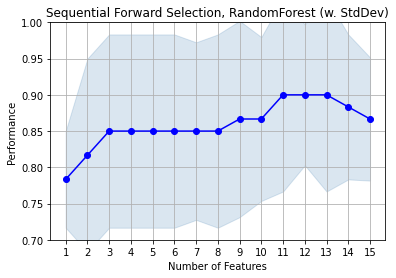

In [ ]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.7, 1])
plt.title('Sequential Forward Selection, RandomForest (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
print('Top 11 Features:')
print('highest score: ' + str(sfs.subsets_[11]['avg_score']))
print('highest indexes: ' + str(sfs.subsets_[11]['feature_idx']))
print('feature names: ' + str(sfs.subsets_[11]['feature_names']))

print('Top 12 Features:')
print('highest score: ' + str(sfs.subsets_[12]['avg_score']))
print('highest indexes: ' + str(sfs.subsets_[12]['feature_idx']))
print('feature names: ' + str(sfs.subsets_[12]['feature_names']))

print('Top 13 Features:')
print('highest score: ' + str(sfs.subsets_[13]['avg_score']))
print('highest indexes: ' + str(sfs.subsets_[13]['feature_idx']))
print('feature names: ' + str(sfs.subsets_[13]['feature_names']))

Top 11 Features:
highest score: 0.9
highest indexes: (2, 4, 7, 8, 13, 14, 20, 21, 24, 66, 80)
feature names: ('dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd5 Cell Density', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'dd7 Aggregate Size ', 'dd5-dd7 Aggregate Size Gradient', 'Presence of  IWP2 [h]', 'dd3 DO 2nd derivative/cell count', 'dd2 Average pH')
Top 12 Features:
highest score: 0.9
highest indexes: (2, 4, 7, 8, 13, 14, 20, 21, 24, 66, 70, 80)
feature names: ('dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd5 Cell Density', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'dd7 Aggregate Size ', 'dd5-dd7 Aggregate Size Gradient', 'Presence of  IWP2 [h]', 'dd3 DO 2nd derivative/cell count', 'Overall density gradient', 'dd2 Average pH')
Top 13 Features:
highest score: 0.9
highest indexes: (2, 4, 7, 8, 13, 14, 20, 21, 24, 30, 66, 70, 80)
feature names: ('dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell 

In [ ]:
data_reduced = data[list(sfs.subsets_[11]['feature_names'])]

result = cross_validate(rf, data_reduced, target_class, cv=10, scoring=metrics)

# create a dataframe with metrics
row = [['Random Forest (FS1)', '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]

rf_metrics = pd.DataFrame(row, columns=col_names)
rf_metrics

,model,accuracy,precision_score,recall_score,mcc
0,Random Forest (FS1),0.867 +/- 0.145,0.877 +/- 0.128,0.950 +/- 0.100,0.676 +/- 0.367


### AdaBoost

In [ ]:
# Choosing Decision Tree with 1 level as the weak learner
ada = AdaBoostClassifier(n_estimators=50, estimator=DecisionTreeClassifier(max_depth=1) ,learning_rate=1)
scores = cross_validate(ada, data, target_class, cv=10, scoring=metrics)

# create a dataframe with metrics
row = [['AdaBoost', '%.3f +/- %.3f' %(scores['test_accuracy'].mean(), scores['test_accuracy'].std()), '%.3f +/- %.3f' %(scores['test_precision'].mean(), scores['test_precision'].std()), '%.3f +/- %.3f' %(scores['test_recall'].mean(), scores['test_recall'].std()), '%.3f +/- %.3f' %(scores['test_mcc'].mean(), scores['test_mcc'].std())]]

metrics_df = pd.DataFrame(row, columns=col_names)
metrics_df

,feature set,accuracy,precision_score,recall_score,mcc
0,AdaBoost,0.700 +/- 0.163,0.748 +/- 0.127,0.830 +/- 0.250,0.253 +/- 0.329


Feature selection with mlxtend:

In [ ]:
sfs = SFS(ada, k_features=15)
sfs.fit(data, target_class)

SequentialFeatureSelector(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                                       learning_rate=1),
                          k_features=15)

In [ ]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)","[0.9166666666666666, 0.9166666666666666, 0.75,...",0.8,"(dd1 Cell Density,)",0.128529,0.1,0.05
2,"(2, 38)","[1.0, 0.9166666666666666, 0.75, 0.833333333333...",0.866667,"(dd1 Cell Density, Average DO concentration gr...",0.109229,0.084984,0.042492
3,"(2, 38, 46)","[1.0, 0.9166666666666666, 0.75, 0.916666666666...",0.883333,"(dd1 Cell Density, Average DO concentration gr...",0.109229,0.084984,0.042492
4,"(2, 38, 46, 101)","[1.0, 1.0, 0.75, 0.9166666666666666, 0.8333333...",0.9,"(dd1 Cell Density, Average DO concentration gr...",0.124908,0.097183,0.048591
5,"(2, 38, 46, 55, 101)","[1.0, 1.0, 0.75, 0.9166666666666666, 0.8333333...",0.9,"(dd1 Cell Density, Average DO concentration gr...",0.124908,0.097183,0.048591
6,"(1, 2, 38, 46, 55, 101)","[1.0, 0.9166666666666666, 0.75, 0.833333333333...",0.866667,"(dd0-dd1 Cell Density Gradient, dd1 Cell Densi...",0.109229,0.084984,0.042492
7,"(1, 2, 38, 46, 55, 58, 101)","[1.0, 1.0, 0.75, 0.9166666666666666, 0.8333333...",0.9,"(dd0-dd1 Cell Density Gradient, dd1 Cell Densi...",0.124908,0.097183,0.048591
8,"(1, 2, 38, 42, 46, 55, 58, 101)","[1.0, 1.0, 0.8333333333333334, 0.9166666666666...",0.916667,"(dd0-dd1 Cell Density Gradient, dd1 Cell Densi...",0.0958,0.074536,0.037268
9,"(1, 2, 3, 38, 42, 46, 55, 58, 101)","[1.0, 0.9166666666666666, 0.8333333333333334, ...",0.9,"(dd0-dd1 Cell Density Gradient, dd1 Cell Densi...",0.080152,0.062361,0.03118
10,"(1, 2, 3, 17, 38, 42, 46, 55, 58, 101)","[1.0, 1.0, 0.75, 0.9166666666666666, 0.8333333...",0.9,"(dd0-dd1 Cell Density Gradient, dd1 Cell Densi...",0.124908,0.097183,0.048591


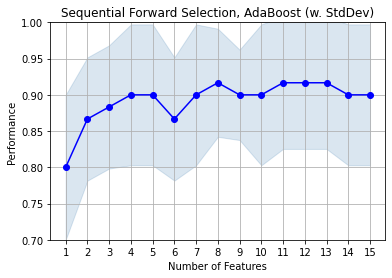

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.7, 1])
plt.title('Sequential Forward Selection, AdaBoost (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
print('Top 11 Features:')
print('highest score: ' + str(sfs.subsets_[11]['avg_score']))
print('highest indexes: ' + str(sfs.subsets_[11]['feature_idx']))
print('feature names: ' + str(sfs.subsets_[11]['feature_names']))

print('Top 12 Features:')
print('highest score: ' + str(sfs.subsets_[12]['avg_score']))
print('highest indexes: ' + str(sfs.subsets_[12]['feature_idx']))
print('feature names: ' + str(sfs.subsets_[12]['feature_names']))

print('Top 13 Features:')
print('highest score: ' + str(sfs.subsets_[13]['avg_score']))
print('highest indexes: ' + str(sfs.subsets_[13]['feature_idx']))
print('feature names: ' + str(sfs.subsets_[13]['feature_names']))

Top 11 Features:
highest score: 0.9166666666666666
highest indexes: (1, 2, 3, 17, 38, 40, 42, 46, 55, 58, 101)
feature names: ('dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'Average DO concentration gradient dd5', 'DO concentration/cell count dd1', 'DO gradient/cell count dd5', 'dd1 Average of 2nd derivative DO', 'dd7 Glucose Concentration')
Top 12 Features:
highest score: 0.9166666666666666
highest indexes: (1, 2, 3, 15, 17, 38, 40, 42, 46, 55, 58, 101)
feature names: ('dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd2 Aggregate Size ', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'Average DO concentration gradient dd5', 'DO concentration/cell count dd1', 'DO gradient/cell count dd5', 'dd1 Average of 2nd derivative DO', 'dd7 Glucose Concentrati

In [ ]:
data_reduced = data[list(sfs.subsets_[11]['feature_names'])]

result = cross_validate(ada, data_reduced, target_class, cv=10, scoring=metrics)

# create a dataframe with metrics
row = [['AdaBoost (FS1)', '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]

ada_metrics = pd.DataFrame(row, columns=col_names)
ada_metrics

,feature set,accuracy,precision_score,recall_score,mcc
0,AdaBoost (FS1),0.817 +/- 0.157,0.887 +/- 0.149,0.880 +/- 0.165,0.579 +/- 0.412


## Everything Together

In [ ]:
import seaborn as sns

def plot_scores(estimator_names, scorers, metrics=['accuracy', 'precision', 'recall', 'mcc']):

    score_lists={}
    for metric in metrics:
        score_lists[metric]=[score['test_'+metric] for score in scorers]
        
    for  i,(title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=_list).set_xticklabels(estimator_names, rotation=45)
        plt.title(title)

In [ ]:
estimator_names = ['xgboost', 'adaboost', 'random_forest']

### KFold CV

Optimal features:

In [ ]:
features = {
    'xgboost': ['dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'DO gradient/cell count dd2', 'DO gradient/cell count dd7', 'dd2 Average of 2nd derivative DO'],
    'adaboost': ['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'Average DO concentration gradient dd5', 'DO concentration/cell count dd1', 'DO gradient/cell count dd5', 'dd1 Average of 2nd derivative DO', 'dd7 Glucose Concentration'],
    'random_forest': ['dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd5 Cell Density', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'dd7 Aggregate Size ', 'dd5-dd7 Aggregate Size Gradient', 'Presence of  IWP2', 'dd3 DO 2nd derivative/cell count', 'dd2 Average pH']
}

metrics_df = pd.DataFrame(columns=col_names)
scorers = []

for estimator in estimators:

  model = Pipeline(steps=[('scale', transformer), estimator])

  data_reduced = data[features[estimator[0]]]

  result = cross_validate(model, data_reduced, target_class, cv=10, scoring=metrics)
  scorers.append(result)
  # create a dataframe with metrics
  row = [[estimator[0], '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row, columns=col_names)], ignore_index=True)
  

metrics_df

,model,accuracy,precision_score,recall_score,mcc
0,xgboost,0.883 +/- 0.130,0.905 +/- 0.123,0.950 +/- 0.100,0.659 +/- 0.403
1,random_forest,0.883 +/- 0.130,0.902 +/- 0.125,0.950 +/- 0.100,0.722 +/- 0.339
2,adaboost,0.817 +/- 0.157,0.887 +/- 0.149,0.880 +/- 0.165,0.579 +/- 0.412


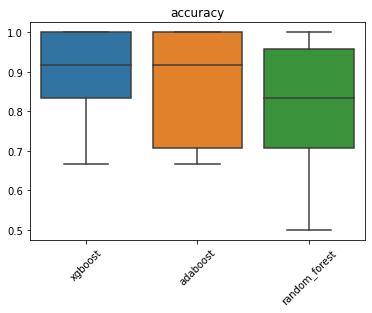

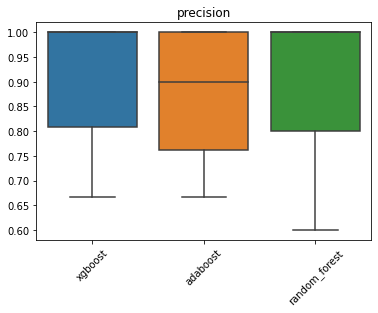

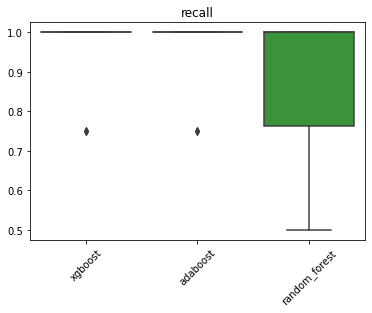

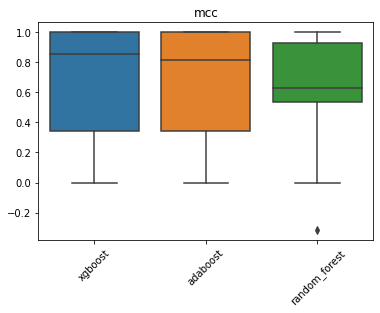

In [ ]:
plot_scores(estimator_names, scorers)

dd5 features:

In [ ]:
features = {
    'xgboost': ['dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'DO gradient/cell count dd2', 'dd2 Average of 2nd derivative DO'],
    'adaboost': ['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'Average DO concentration gradient dd5', 'DO concentration/cell count dd1', 'DO gradient/cell count dd5', 'dd1 Average of 2nd derivative DO'],
    'random_forest': ['dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd5 Cell Density', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'dd7 Aggregate Size ', 'dd5-dd7 Aggregate Size Gradient', 'Presence of  IWP2', 'dd3 DO 2nd derivative/cell count', 'dd2 Average pH']
}

metrics_df = pd.DataFrame(columns=col_names)
scorers = []

for estimator in estimators:

  model = Pipeline(steps=[('scale', transformer), estimator])

  data_reduced = data[features[estimator[0]]]

  result = cross_validate(model, data_reduced, target_class, cv=10, scoring=metrics)
  scorers.append(result)
  # create a dataframe with metrics
  row = [[estimator[0], '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row, columns=col_names)], ignore_index=True)

metrics_df

,model,accuracy,precision_score,recall_score,mcc
0,xgboost,0.833 +/- 0.149,0.902 +/- 0.125,0.880 +/- 0.165,0.589 +/- 0.422
1,random_forest,0.883 +/- 0.130,0.902 +/- 0.125,0.950 +/- 0.100,0.722 +/- 0.339
2,adaboost,0.800 +/- 0.145,0.887 +/- 0.119,0.850 +/- 0.255,0.605 +/- 0.280


### Monte Carlo CV

In [ ]:
from sklearn.model_selection import ShuffleSplit
shuffle_split=ShuffleSplit(test_size=0.3,train_size=0.5,n_splits=10)

features = {
    'xgboost': ['dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'DO gradient/cell count dd2', 'DO gradient/cell count dd7', 'dd2 Average of 2nd derivative DO'],
    'adaboost': ['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'Average DO concentration gradient dd5', 'DO concentration/cell count dd1', 'DO gradient/cell count dd5', 'dd1 Average of 2nd derivative DO', 'dd7 Glucose Concentration'],
    'random_forest': ['dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd5 Cell Density', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'dd7 Aggregate Size ', 'dd5-dd7 Aggregate Size Gradient', 'Presence of  IWP2', 'dd3 DO 2nd derivative/cell count', 'dd2 Average pH']
}

metrics_df = pd.DataFrame(columns=col_names)

for estimator in estimators:

  model = Pipeline(steps=[('scale', transformer), estimator])

  data_reduced = data[features[estimator[0]]]

  result = cross_validate(model, data_reduced, target_class, cv=shuffle_split, scoring=metrics)

  # create a dataframe with metrics
  row = [[estimator[0], '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row, columns=col_names)], ignore_index=True)

metrics_df

,model,accuracy,precision_score,recall_score,mcc
0,xgboost,0.828 +/- 0.084,0.853 +/- 0.099,0.920 +/- 0.061,0.586 +/- 0.173
1,random_forest,0.778 +/- 0.105,0.845 +/- 0.158,0.885 +/- 0.096,0.528 +/- 0.165
2,adaboost,0.722 +/- 0.108,0.799 +/- 0.115,0.844 +/- 0.132,0.278 +/- 0.227


With dd5 features:

In [ ]:
features = {
    'xgboost': ['dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'DO gradient/cell count dd2', 'dd2 Average of 2nd derivative DO'],
    'adaboost': ['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'Average DO concentration gradient dd5', 'DO concentration/cell count dd1', 'DO gradient/cell count dd5', 'dd1 Average of 2nd derivative DO'],
    'random_forest': ['dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd5 Cell Density', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'dd5-dd7 Aggregate Size Gradient', 'Presence of  IWP2', 'dd3 DO 2nd derivative/cell count', 'dd2 Average pH']
}

metrics_df = pd.DataFrame(columns=col_names)

for estimator in estimators:

  model = Pipeline(steps=[('scale', transformer), estimator])

  data_reduced = data[features[estimator[0]]]

  result = cross_validate(model, data_reduced, target_class, cv=shuffle_split, scoring=metrics)

  # create a dataframe with metrics
  row = [[estimator[0], '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row, columns=col_names)], ignore_index=True)

metrics_df

,model,accuracy,precision_score,recall_score,mcc
0,xgboost,0.717 +/- 0.058,0.758 +/- 0.085,0.843 +/- 0.068,0.308 +/- 0.208
1,random_forest,0.811 +/- 0.122,0.820 +/- 0.129,0.954 +/- 0.050,0.533 +/- 0.279
2,adaboost,0.756 +/- 0.075,0.793 +/- 0.061,0.881 +/- 0.079,0.401 +/- 0.221


With dd3 features:

In [ ]:
features = {
    'xgboost': ['dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'DO gradient/cell count dd2', 'dd2 Average of 2nd derivative DO'],
    'adaboost': ['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'DO concentration/cell count dd1', 'dd1 Average of 2nd derivative DO'],
    'random_forest': ['dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'Presence of  IWP2', 'dd3 DO 2nd derivative/cell count', 'dd2 Average pH']
}

metrics_df = pd.DataFrame(columns=col_names)

for estimator in estimators:

  model = Pipeline(steps=[('scale', transformer), estimator])

  data_reduced = data[features[estimator[0]]]

  result = cross_validate(model, data_reduced, target_class, cv=shuffle_split, scoring=metrics)

  # create a dataframe with metrics
  row = [[estimator[0], '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row, columns=col_names)], ignore_index=True)

metrics_df

,model,accuracy,precision_score,recall_score,mcc
0,xgboost,0.767 +/- 0.096,0.819 +/- 0.096,0.872 +/- 0.160,0.474 +/- 0.136
1,random_forest,0.906 +/- 0.050,0.936 +/- 0.048,0.937 +/- 0.077,0.772 +/- 0.109
2,adaboost,0.794 +/- 0.090,0.844 +/- 0.090,0.886 +/- 0.122,0.495 +/- 0.246


### Leave One Out

In [ ]:
from sklearn.model_selection import LeaveOneOut

features = {
    'xgboost': ['dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'DO gradient/cell count dd2', 'DO gradient/cell count dd7', 'dd2 Average of 2nd derivative DO'],
    'adaboost': ['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'Average DO concentration gradient dd5', 'DO concentration/cell count dd1', 'DO gradient/cell count dd5', 'dd1 Average of 2nd derivative DO', 'dd7 Glucose Concentration'],
    'random_forest': ['dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd5 Cell Density', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'dd7 Aggregate Size ', 'dd5-dd7 Aggregate Size Gradient', 'Presence of  IWP2', 'dd3 DO 2nd derivative/cell count', 'dd2 Average pH']
}

metrics_df = pd.DataFrame(columns=col_names)
loo=LeaveOneOut()

for estimator in estimators:

  model = Pipeline(steps=[('scale', transformer), estimator])
  data_reduced = data[features[estimator[0]]]

  result = cross_validate(model, data_reduced, target_class, cv=loo, scoring=metrics)

  # create a dataframe with metrics
  row = [[estimator[0], '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row, columns=col_names)], ignore_index=True)


In [ ]:
metrics_df

,model,accuracy,precision_score,recall_score,mcc
0,xgboost,0.900 +/- 0.300,0.667 +/- 0.471,0.667 +/- 0.471,0.000 +/- 0.000
1,random_forest,0.867 +/- 0.340,0.650 +/- 0.477,0.650 +/- 0.477,0.000 +/- 0.000
2,adaboost,0.767 +/- 0.423,0.617 +/- 0.486,0.617 +/- 0.486,0.000 +/- 0.000


In [ ]:
from sklearn.model_selection import LeaveOneOut

features = {
    'xgboost': ['dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'DO gradient/cell count dd2', 'dd2 Average of 2nd derivative DO'],
    'adaboost': ['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'Average DO concentration gradient dd5', 'DO concentration/cell count dd1', 'DO gradient/cell count dd5', 'dd1 Average of 2nd derivative DO'],
    'random_forest': ['dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd5 Cell Density', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'dd5-dd7 Aggregate Size Gradient', 'Presence of  IWP2', 'dd3 DO 2nd derivative/cell count', 'dd2 Average pH']
}

col_names = ['model', 'accuracy', 'precision_score', 'recall_score', 'mcc']
metrics_df = pd.DataFrame(columns=col_names)
loo=LeaveOneOut()

for estimator in estimators:

  model = Pipeline(steps=[('scale', transformer), estimator])
  data_reduced = data[features[estimator[0]]]

  result = cross_validate(model, data_reduced, target_class, cv=loo, scoring=metrics)

  # create a dataframe with metrics
  row = [[estimator[0], '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row, columns=col_names)], ignore_index=True)

In [ ]:
metrics_df

,model,accuracy,precision_score,recall_score,mcc
0,xgboost,0.817 +/- 0.387,0.617 +/- 0.486,0.617 +/- 0.486,0.000 +/- 0.000
1,random_forest,0.817 +/- 0.387,0.633 +/- 0.482,0.633 +/- 0.482,0.000 +/- 0.000
2,adaboost,0.700 +/- 0.458,0.550 +/- 0.497,0.550 +/- 0.497,0.000 +/- 0.000


In [ ]:
features = {
    'xgboost': ['dd1 Cell Density', 'Preculture Time', 'Start Preculture Perfusion d1-d2', 'DO gradient/cell count dd2', 'dd2 Average of 2nd derivative DO'],
    'adaboost': ['dd0-dd1 Cell Density Gradient', 'dd1 Cell Density', 'dd1-dd2 Cell Density Gradient', 'dd3 Aggregate Size ', 'Average DO concentration gradient dd1', 'Average DO concentration gradient dd3', 'DO concentration/cell count dd1', 'dd1 Average of 2nd derivative DO'],
    'random_forest': ['dd1 Cell Density', 'dd2 Cell Density', 'dd3-dd5 Cell Density Gradient', 'dd1 Aggregate Size ', 'dd1-dd2 Aggregate Size Gradient', 'Presence of  IWP2', 'dd3 DO 2nd derivative/cell count', 'dd2 Average pH']
}

metrics_df = pd.DataFrame(columns=col_names)
loo=LeaveOneOut()

for estimator in estimators:

  model = Pipeline(steps=[('scale', transformer), estimator])
  data_reduced = data[features[estimator[0]]]

  result = cross_validate(model, data_reduced, target_class, cv=loo, scoring=metrics)

  # create a dataframe with metrics
  row = [[estimator[0], '%.3f +/- %.3f' %(result['test_accuracy'].mean(), result['test_accuracy'].std()), '%.3f +/- %.3f' %(result['test_precision'].mean(), result['test_precision'].std()), '%.3f +/- %.3f' %(result['test_recall'].mean(), result['test_recall'].std()), '%.3f +/- %.3f' %(result['test_mcc'].mean(), result['test_mcc'].std())]]
  metrics_df = pd.concat([metrics_df, pd.DataFrame(row, columns=col_names)], ignore_index=True)

In [ ]:
metrics_df

,model,accuracy,precision_score,recall_score,mcc
0,xgboost,0.817 +/- 0.387,0.617 +/- 0.486,0.617 +/- 0.486,0.000 +/- 0.000
1,random_forest,0.833 +/- 0.373,0.633 +/- 0.482,0.633 +/- 0.482,0.000 +/- 0.000
2,adaboost,0.783 +/- 0.412,0.600 +/- 0.490,0.600 +/- 0.490,0.000 +/- 0.000
